Problem Description:

An advertising company sells a service of buying keywords in search engines on behalf of their customers. They’re trying to optimise their keyword and funds allocation. The first towards the optimal solution is to predict performance by keyword and fund.

Goal:

Predicting for any keyword (not necessarily the ones in the dataset file), CPC, and market (US/UK) the traffic a website would receive (I.e., the clicks).

Task Evaluation:

The evaluation of the task will use an input dataset of new keywords and CPC for each market (US/UK) at the date of 14/2/2013. The model's results will be compared to real results for that day.

Questions:

    1. How did you manipulate the data, and why? Illustrate your answer with plots.
    2. How did you perform NLP, if any?
    3. How did you model the problem, and why?
    4. How did you evaluate your model? What were the results of the evaluation?
    5. If you had extra time, what would you do next?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data['AveragePosition'] = data['Average.Position']
data.drop('Average.Position', axis=1, inplace=True)

# Data cleaning and exploration

We remove the rows with any null values

In [4]:
data.dropna(inplace=True)

In [5]:
data.shape

(352540, 9)

We have now removed a total of 3514 rows, which is only 0.98% of the original dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352540 entries, 0 to 356053
Data columns (total 9 columns):
Date               352540 non-null int64
Market             352540 non-null object
Keyword            352540 non-null object
CPC                352540 non-null float64
Clicks             352540 non-null float64
CTR                352540 non-null object
Impressions        352540 non-null float64
Cost               352540 non-null float64
AveragePosition    352540 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 26.9+ MB


Next we have to convert the CTR values from string to float values

In [7]:
data.CTR = data.CTR.apply(lambda x: x[:-1]).astype('float64')

In [8]:
data.head()

,Date,Market,Keyword,CPC,Clicks,CTR,Impressions,Cost,AveragePosition
0,20120524,US-Market,secure online back up,0.0,0.00,0.0,0.0,0.00,0.0
1,20120524,US-Market,agile management software,1.2,21.22,8.2,260.0,25.45,1.0
2,20120524,US-Market,crm for financial,0.0,0.00,0.0,0.0,0.00,0.0
3,20120524,US-Market,disaster recovery planning for it,0.0,0.00,0.0,0.0,0.00,0.0
4,20120524,US-Market,tracking a vehicle,0.0,0.00,0.0,0.0,0.00,0.0


In [9]:
data.describe()

,Date,CPC,Clicks,CTR,Impressions,Cost,AveragePosition
count,3.525400e+05,352540.000000,352540.000000,352540.000000,3.525400e+05,352540.000000,352540.000000
mean,2.012271e+07,14.287964,220.299838,1.630900,9.758862e+03,1900.441204,0.611163
std,3.589467e+03,37.882436,1719.222177,2.033744,7.145521e+04,10060.075649,0.644052
min,2.012052e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.012090e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,2.012102e+07,1.080000,2.090000,0.800000,1.270000e+02,7.930000,1.000000
75%,2.012122e+07,12.070000,34.870000,2.800000,1.553000e+03,369.810000,1.000000
max,2.013021e+07,632.730000,89233.580000,23.700000,3.666042e+06,285716.050000,12.000000


Notice that there are a lot of zeroes in the dataset. For the six numeric features (CPC, CTR, clicks, impressions, cost and average position), **the 25th percentile is zero**. In addition, **the CPC, CTR, clicks, impressions and cost features are heavily skewed to the right** as easily determined by comparing their 75th percetile to their mean values. We might need to eliminate a lot of rows in the dataset to have meaningful predictions. In addition, taking the logarithm of Clicks and Impressions will improve their suitability for machine learning models.

In [10]:
zeroCPCrows = data[data.CPC == 0.0]
print(f'There are {zeroCPCrows.shape[0]} rows with CPC = 0')

There are 148945 rows with CPC = 0


In [11]:
print(zeroCPCrows.Clicks.sum(), zeroCPCrows.CTR.sum(), zeroCPCrows.Cost.sum())

0.0 0.0 0.0


This indicates that **a zero CPC immediately implies zero Clicks, CTR and cost** in the dataset.

**42% of the current dataset has zero CPC, clicks, CTR and cost.** This is an overwhelmingly large portion of the dataset and they will greatly affect our analysis. But before making decisions, first let's examine this portion of the dataset further

In [12]:
subset_zeroCPCrows = zeroCPCrows[(zeroCPCrows.Impressions != 0) | (zeroCPCrows.AveragePosition != 0)]
subset_zeroCPCrows.shape[0]

48

There are 48 rows with zero CPC but nonzero Impressions or Average Position

In [13]:
fullyzeroCPCrows = zeroCPCrows[(zeroCPCrows.Impressions == 0) & (zeroCPCrows.AveragePosition == 0)]
fullyzeroCPCrows.shape[0],fullyzeroCPCrows.Keyword.nunique()

(148897, 837)

There are 148897 rows with zero CPC, Impressions and Average Position, among which there are 837 unique keywords

According to Google Ads:
- CTR is the total number of clicks that your ad receives divided by the total number of times your ad is shown. A high CPC shows that users find your ads useful and relevant. [Source.](https://support.google.com/google-ads/answer/2615875?hl=en) $ \textbf{CTR} = \frac{\textbf{total clicks}}{\textbf{total impressions}}$
- CPC is the average amount that you've been charged for a click on your ad. [Source.](https://support.google.com/google-ads/answer/14074?hl=en&ref_topic=24937) $ \textbf{CPC} = \frac{\textbf{total cost}}{\textbf{total clicks}}$
- Ad position is the order in which your ad appears on a page in relation to other ads. For example, an ad position of "1" means that your ad has the highest position on the page relative to other ads of the same type. [Source.](https://support.google.com/google-ads/answer/6300?hl=en&ref_topic=24937) The 'Position 0' is commonly used to refer to ads that land as the featured snippet in a google search query. ([Source1](https://www.searchenginejournal.com/content-types-position-zero/232453/#close), [Source2](https://www.searchenginejournal.com/content-types-position-zero/232453/#close)) However Google only introduced featured snippets in 2014, but our dataset contains data from 2012-2013

## Our ML strategy

A large portion (42%) of the dataset contains zeroes for the numeric features (CPC, CTR, Clicks, etc).There are multiple possible interpretations for zero CPC. For example, a keyword might have zero CPC because it's free to use and deemed unpopular. A zero CPC might be an error in the data collection procedure. Also notice that almost all rows with zero CPC had zero Average Position, and this might have a relation with the fact that 'Position 0' is associated with an ad landing in the featured snippet, which might be free-of-cost for the advertiser. However this last interpretation is troublesome because as mentioned, featured snippets have not yet existed at the time of the dataset's collection. Regardless, since 42% of the data will have zero values for six numeric features, they will heavily pull the predictor values to the left.

**For a more stable result we will get rid of the rows with zero CPC.**

Now let us formulate the objective in formal terms. Our input features are the following:
- date
- market (US/UK) - binary categorical variable
- keyword - string variable
- CPC - float variable

Our target variables are the following, all numerical:
- CTR
- Clicks
- Impressions
- Cost
- AveragePosition

We have then a multiple-output regression problem. However because the outputs are related, we can use the following formulas:
$$ \textbf{impressions} = \frac{\textbf{clicks}}{\textbf{CTR}} ; \quad \textbf{Cost} = \textbf{clicks}\times \textbf{CPC}$$

Thus we can opt to only predict CTR, number of clicks and average position, and then compute the number of impressions and cost afterwards.

In [14]:
data = data[data.CPC != 0.0].copy()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203595 entries, 1 to 356039
Data columns (total 9 columns):
Date               203595 non-null int64
Market             203595 non-null object
Keyword            203595 non-null object
CPC                203595 non-null float64
Clicks             203595 non-null float64
CTR                203595 non-null float64
Impressions        203595 non-null float64
Cost               203595 non-null float64
AveragePosition    203595 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 15.5+ MB


## Further data exploration and data preparation

This is the distribution of Market values:

In [16]:
data.Market.value_counts(normalize=True)

US-Market    0.682757
UK-Market    0.317243
Name: Market, dtype: float64

This is the distribution of date values per year:

In [17]:
data['Year'] = data.Date.astype('str').apply(lambda x: x[:4]).astype('int')

In [18]:
data.Year.value_counts(normalize=True)

2012    0.794302
2013    0.205698
Name: Year, dtype: float64

This is the distribution of rows for different months in 2012. The dataset starts from May until December 2012.

In [19]:
data['Month'] = data.Date.astype('str').apply(lambda x: x[4:6]).astype('int')

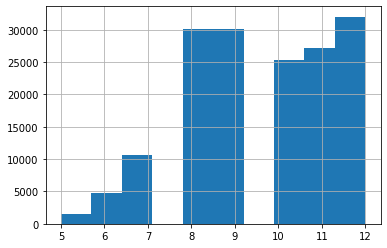

In [20]:
data.Month[data.Year == 2012].hist()

The graph below is for 2013. Note that only January and February are in the dataset

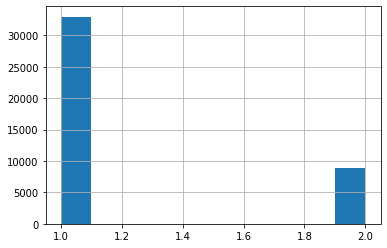

In [21]:
data.Month[data.Year == 2013].hist()

In [22]:
data.describe()

,Date,CPC,Clicks,CTR,Impressions,Cost,AveragePosition,Year,Month
count,2.035950e+05,203595.000000,203595.000000,203595.000000,2.035950e+05,203595.000000,203595.000000,203595.000000,203595.000000
mean,2.012286e+07,24.740681,381.465678,2.824026,1.689818e+04,3290.756365,1.056797,2012.205698,7.908234
std,3.703616e+03,47.184142,2248.686337,1.947453,9.338380e+04,13064.050135,0.484376,0.404211,3.752348
min,2.012052e+07,0.010000,0.000000,0.000000,1.200000e+01,0.000000,1.000000,2012.000000,1.000000
25%,2.012090e+07,2.500000,5.390000,1.300000,2.620000e+02,31.390000,1.000000,2012.000000,7.000000
50%,2.012103e+07,9.130000,23.990000,2.500000,1.052000e+03,233.230000,1.000000,2012.000000,9.000000
75%,2.012122e+07,25.670000,114.660000,3.900000,4.721500e+03,1372.725000,1.000000,2012.000000,11.000000
max,2.013021e+07,632.730000,89233.580000,23.700000,3.666042e+06,285716.050000,12.000000,2013.000000,12.000000


Important observations:
- For AveragePosition, the 75th percentile is 1.0, and actually 95% of the data have value 1.0 (see next cell)
- The maximum value of CPC is 632 while the 50th percentile is 9.13 and the standard deviation is 24.74. Applying logarithm of base 2 will help normalize this feature.
- The maximum value of Clicks is four orders of magnitude higher than its 50th percentile, meanwhile its mean is 381 but its standard deviation is 2248. A stronger transformation is needed. We will use logarithm with base 10.
- We can also observe a similar situation with Impressions and Cost, so we will also use logarithm with base 10.

In [23]:
data.AveragePosition.value_counts(normalize=True).head()

1.0    0.953918
1.1    0.015767
1.2    0.005486
1.3    0.003109
1.5    0.001970
Name: AveragePosition, dtype: float64

In [24]:
data.CPC = np.log2(data.CPC)
data.Clicks = np.log10(data.Clicks.replace(0,0.0001))
data.Impressions = np.log10(data.Impressions.replace(0,0.0001))
data.Cost = np.log10(data.Cost.replace(0,0.0001))

We now plot histograms of the four transformed features, and indeed we have succeeded in normalizing the values

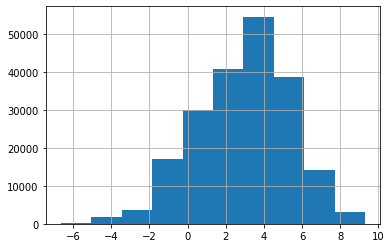

In [25]:
data.CPC.hist()

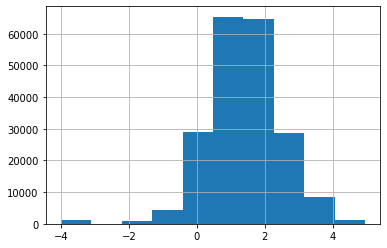

In [26]:
data.Clicks.hist()

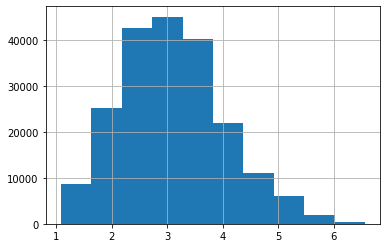

In [27]:
data.Impressions.hist()

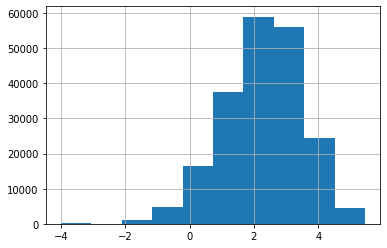

In [28]:
data.Cost.hist()

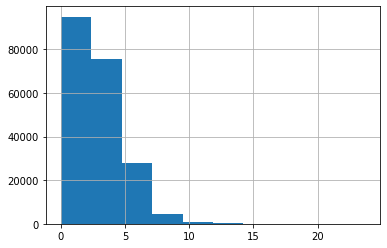

In [29]:
data.CTR.hist()

In [31]:
data.head()

,Date,Market,Keyword,CPC,Clicks,CTR,Impressions,Cost,AveragePosition,Year,Month
1,20120524,US-Market,agile management software,0.263034,1.326745,8.2,2.414973,1.405688,1.0,2012,5
9,20120524,US-Market,android app developers,-0.599462,1.367542,8.6,2.431364,1.184975,1.0,2012,5
13,20120524,US-Market,android application developer,0.028569,1.671358,8.6,2.737193,1.679155,1.0,2012,5
14,20120524,US-Market,android app developer,0.378512,2.168674,6.0,3.392521,2.283279,1.0,2012,5
17,20120524,US-Market,mobile applications developers,-0.810966,1.336260,8.3,2.414973,1.090258,1.0,2012,5


In [32]:
data.to_csv('cleaned_data.csv', index_label=False)